In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import plotting_module

In [2]:
dataset = xr.open_dataset("tco100_omimls_oct2004_to_dec2024_1by1.nc")
dataset

<xarray.Dataset> Size: 63MB
Dimensions:  (months: 243, y_elements: 180, x_elements: 360)
Dimensions without coordinates: months, y_elements, x_elements
Data variables:
    TropoO3  (months, y_elements, x_elements) float32 63MB ...
Attributes:
    Title:    OMI/MLS Ground-to-100hPa Column Ozone for TOARII, etc.

OMI/MLS Ground-to-300hPa Column Ozone for TOARII *y_elements: latitude, x_elements: longitude, period: October 2004 - December 2024

So now it is time for some data cleaning, there should not be negative values in the data

In [3]:
ozone = dataset["TropoO3"]
cleaned_ozone_dataset = ozone.where(ozone >= 0)
dataset["TropoO3"] = cleaned_ozone_dataset

In [4]:
ozone = cleaned_ozone_dataset 

# adding month from attributes to coordinate
month = ozone.attrs['Month'].split(',')
first_month = month[0]                              # October 2004
last_month = month[-1].replace(' ', '')             # December 2024

start_date = datetime.strptime(first_month, "%b%Y")
end_date = datetime.strptime(last_month, "%b%Y")

time_coords = pd.date_range(start=start_date, end=end_date, freq='MS')

In [5]:
# renaming and assigning/removing dimensions
ozone = ozone.assign_coords(time=('months', time_coords))
ozone = ozone.rename({"time": "yearmonth",'y_elements': 'latitude', 'x_elements': 'longitude'})
ozone = ozone.swap_dims({'months': 'yearmonth'})

Subsetting necessary months. This is January 2005 - December 2024 ONLY

In [6]:
ozone_subsetted = ozone.sel(yearmonth=slice("2005-01-01", "2024-12-01")) ####

In [7]:
# grouping by calendar month
monthly_mean = ozone_subsetted.groupby('yearmonth.month').mean('yearmonth')
monthly_stdev = ozone_subsetted.groupby('yearmonth.month').std('yearmonth') # group it with means

In [8]:
monthly_mean = monthly_mean.assign_attrs(_FillValue="-999",name="Tropospheric Ozone Mean, Ground to 100 hPa", latitude="-75.5, -59.5, -58.5, ..., 59.5, 75.5")
monthly_stdev = monthly_stdev.assign_attrs(_FillValue="-999",name="Tropospheric Ozone STDEV, Ground to 100 hPa", latitude="-75.5, -59.5, -58.5, ..., 59.5, 75.5")

del monthly_mean.attrs['Month']
del monthly_stdev.attrs['Month']

#monthly_mean

In [9]:
# adding lat/lon from attributes to coordinates
lat_coords = ozone_subsetted.attrs['latitude'].split(',')
first_lat = float(lat_coords[0])
last_lat = float(lat_coords[-1])

lon_coords = ozone_subsetted.attrs['longitude'].split(',')
first_lon = float(lon_coords[0])
last_lon = float(lon_coords[-1])

lon_coords = np.arange(first_lon, 180.5, 1)
lat_coords = np.arange(first_lat,90.5, 1)

monthly_mean = monthly_mean.assign_coords(
    longitude=('longitude', lon_coords),
    latitude=('latitude', lat_coords)
)

monthly_stdev = monthly_stdev.assign_coords(
    longitude=('longitude', lon_coords),
    latitude=('latitude', lat_coords)
)

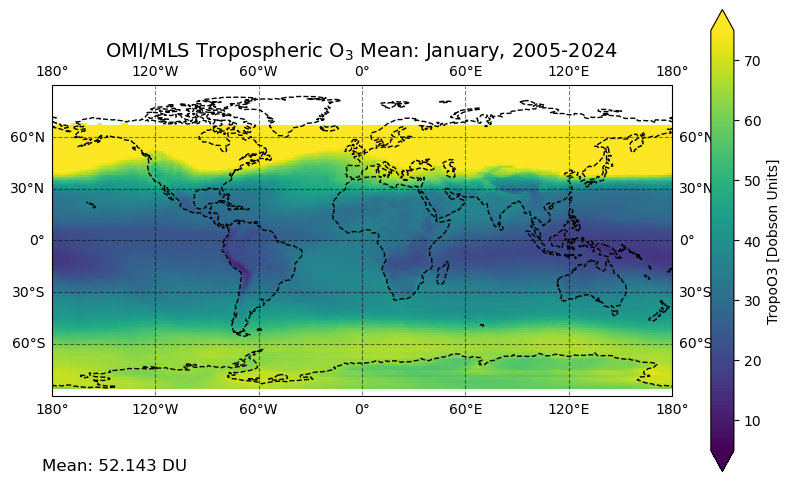

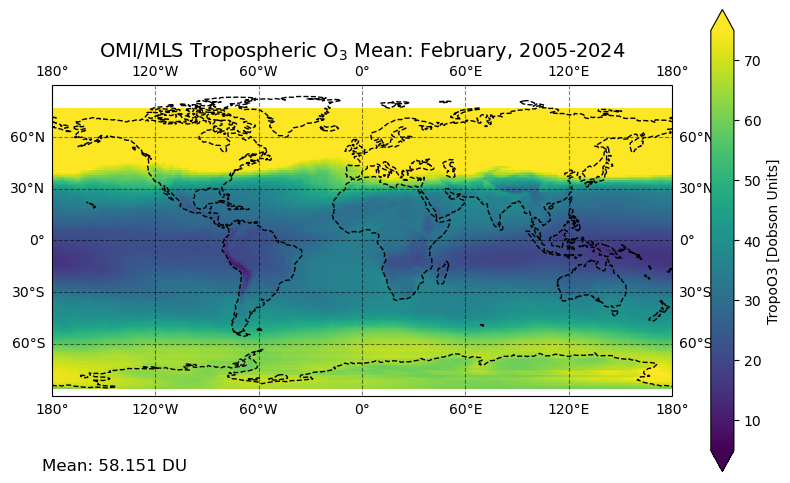

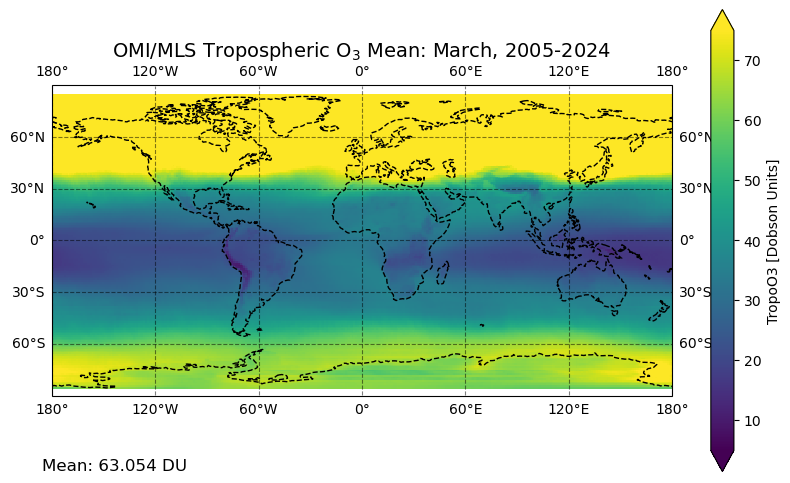

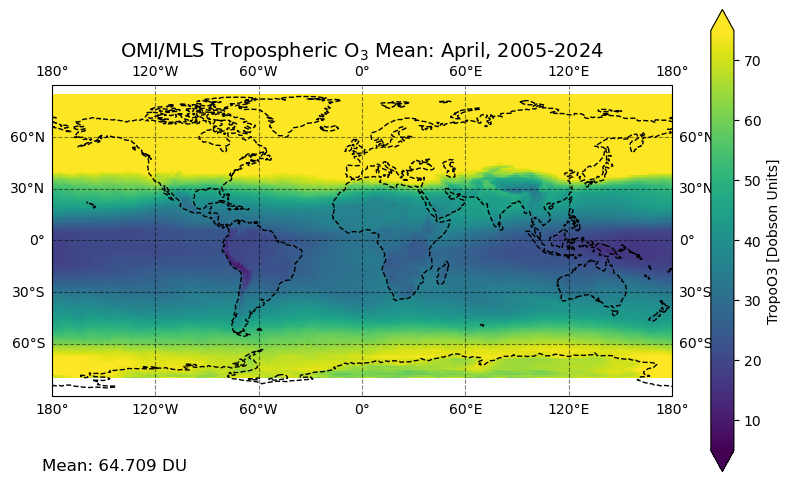

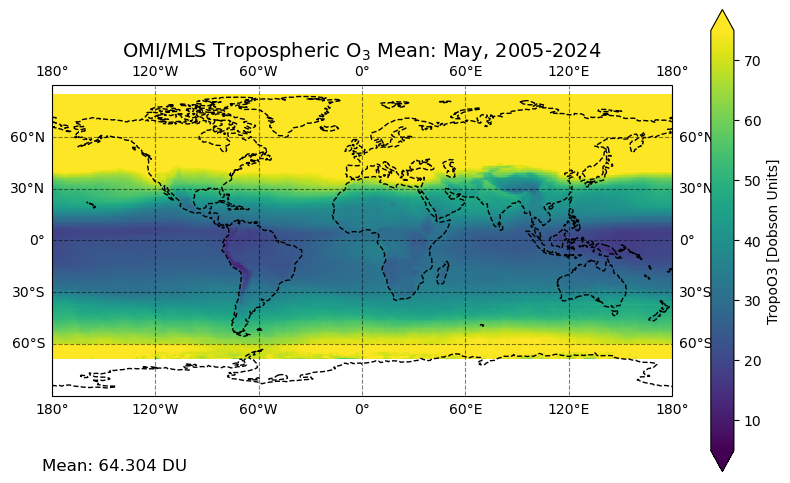

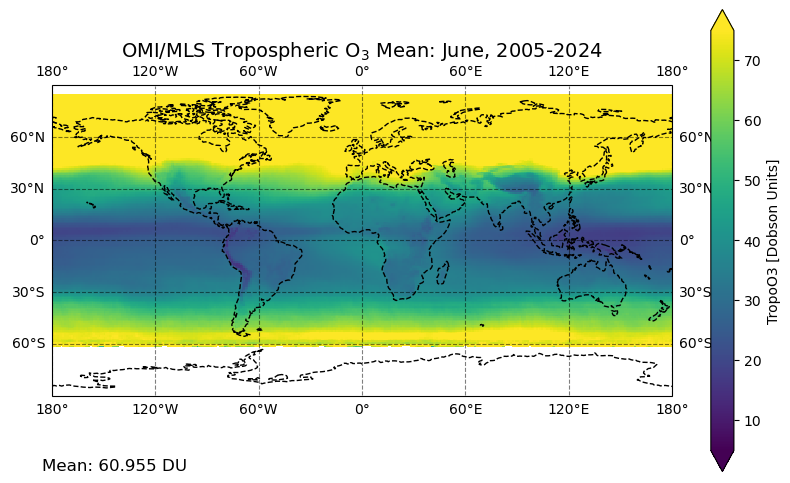

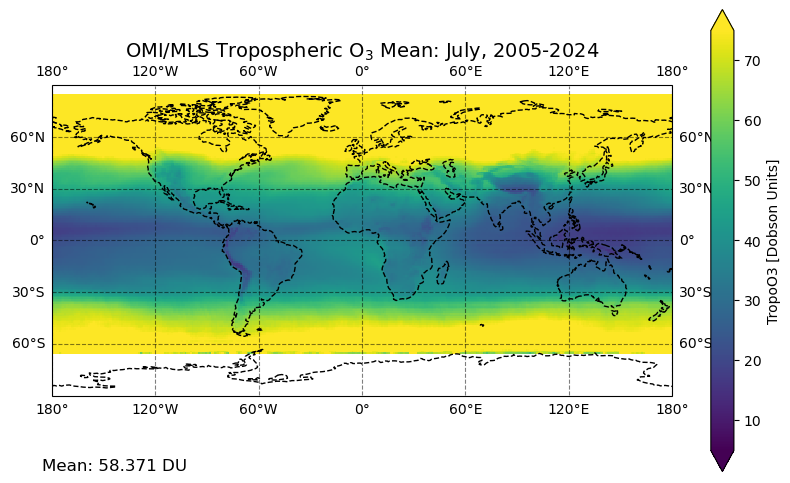

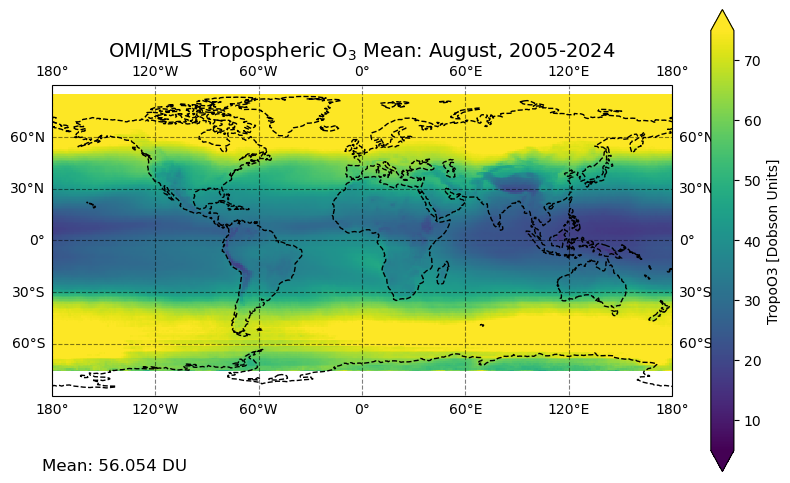

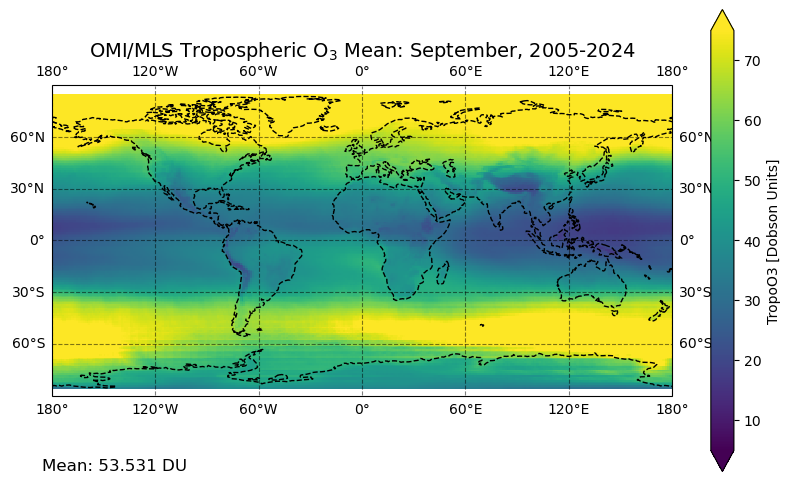

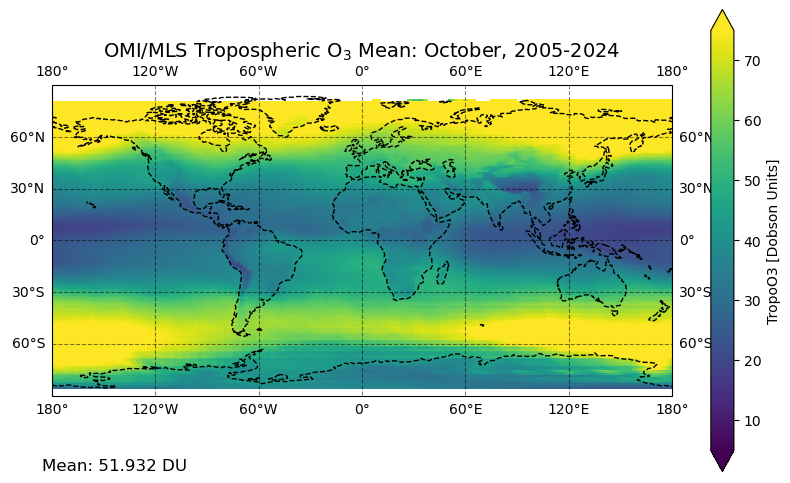

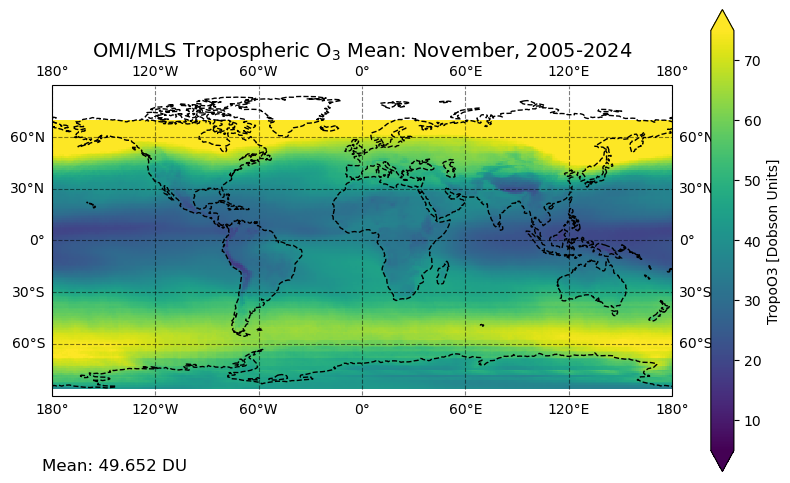

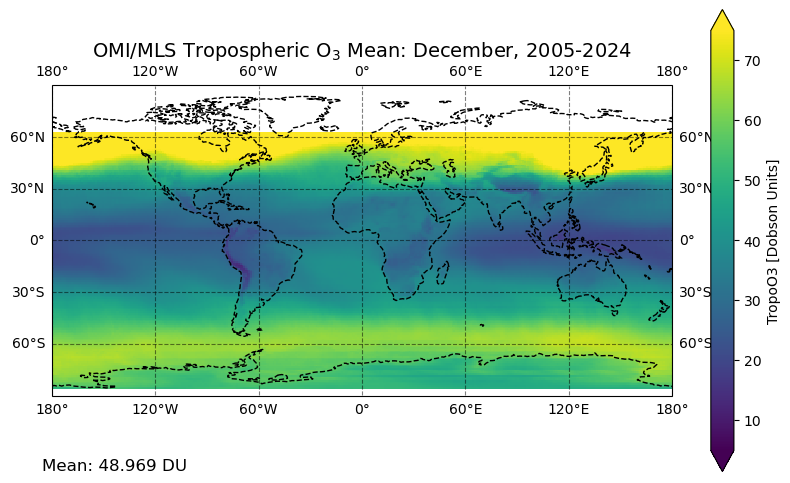

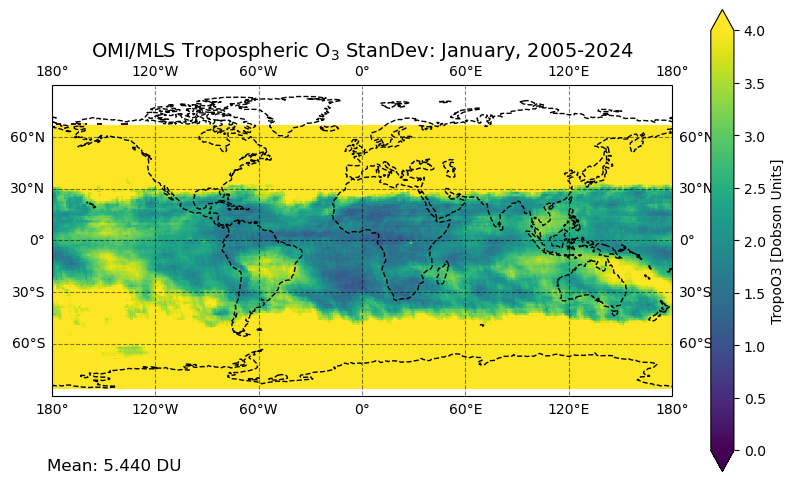

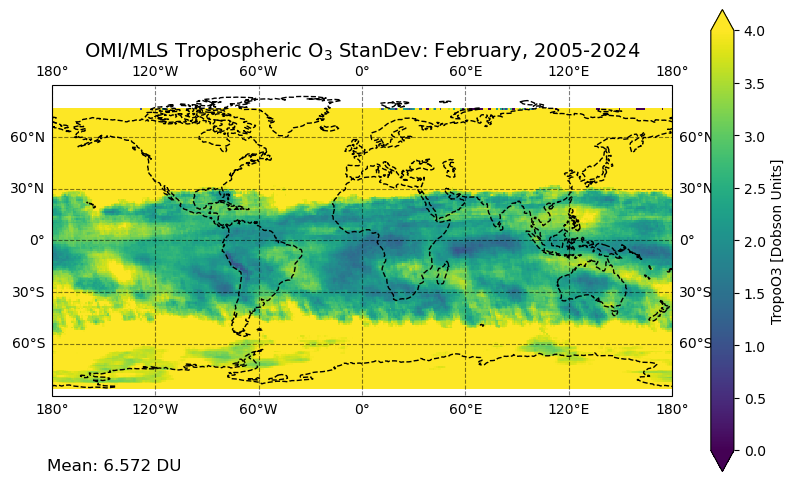

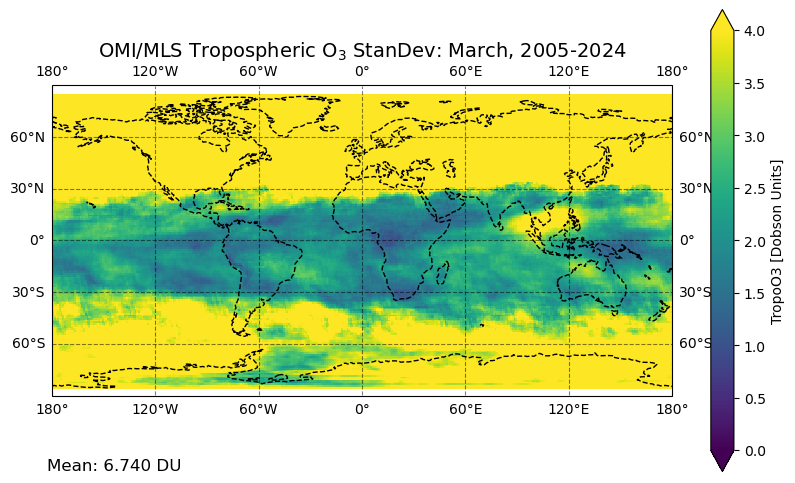

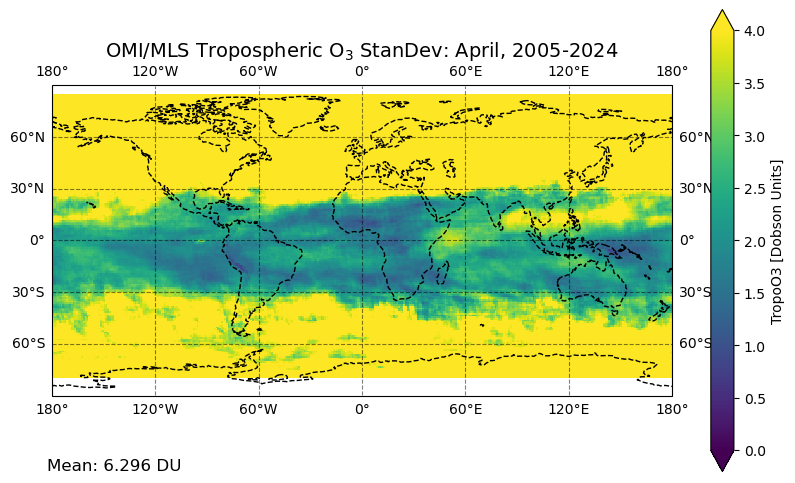

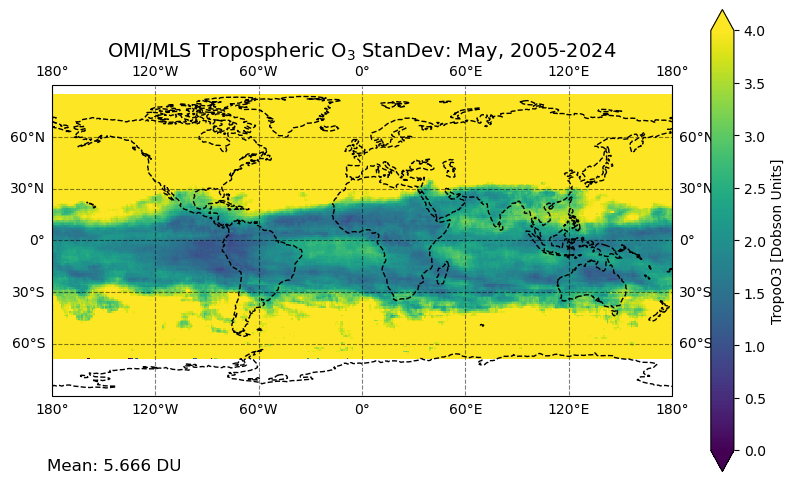

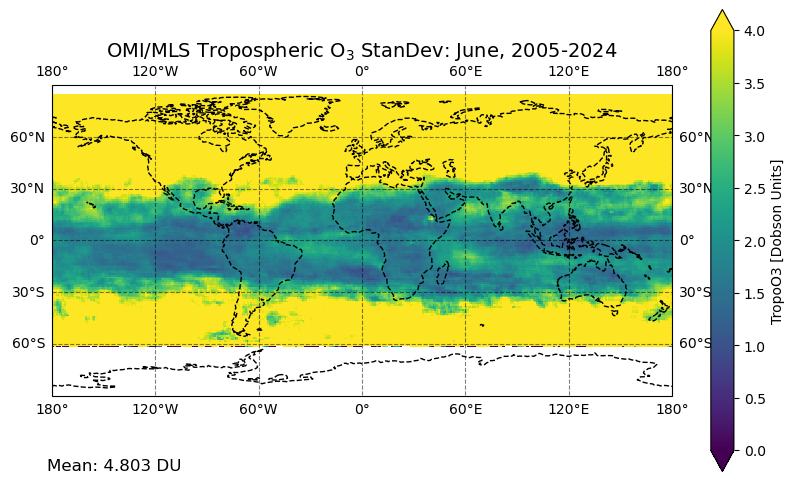

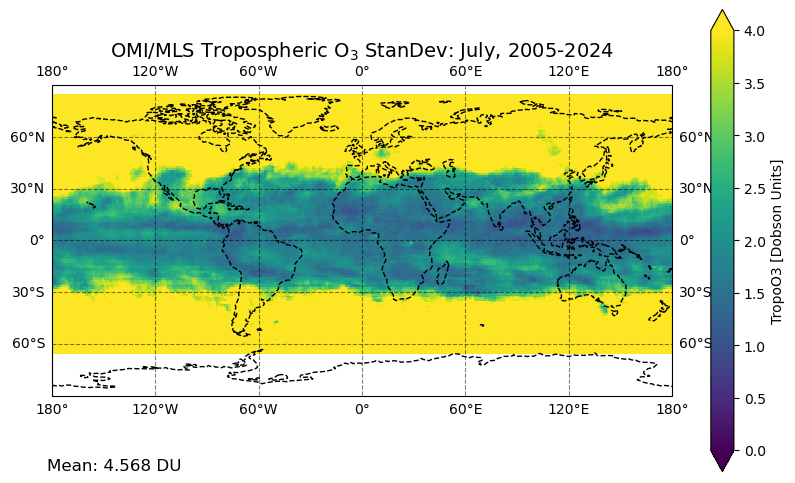

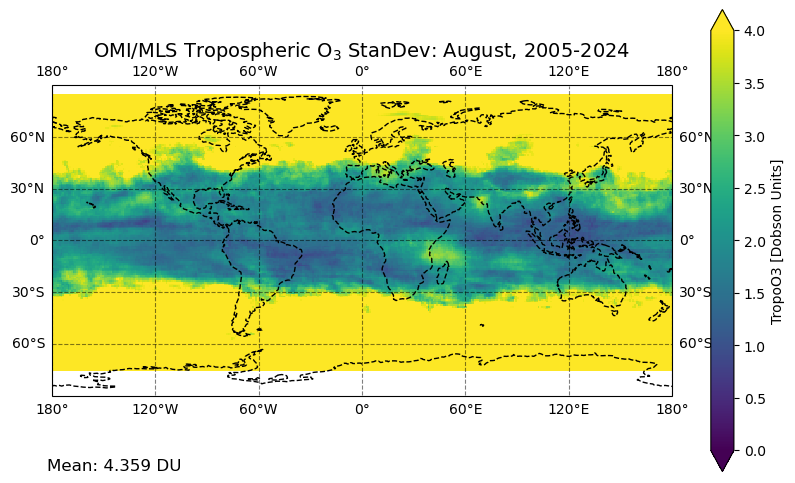

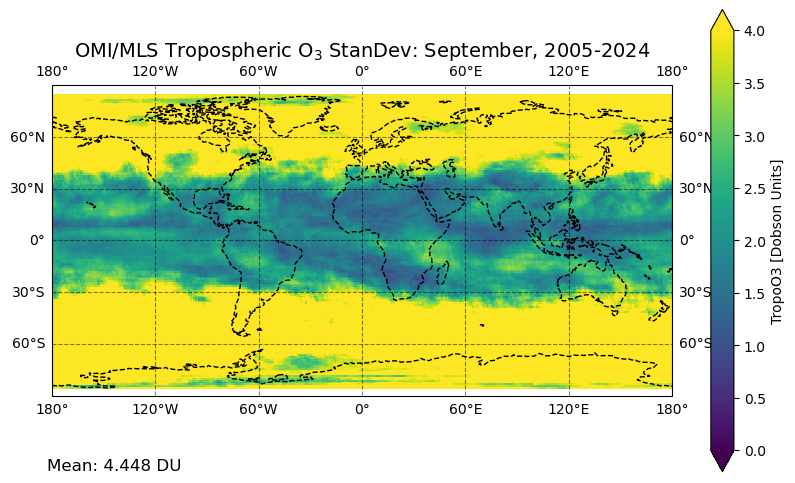

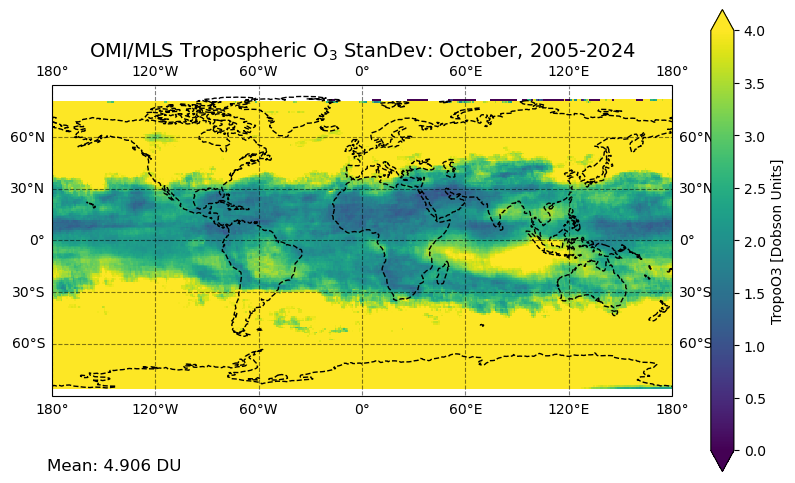

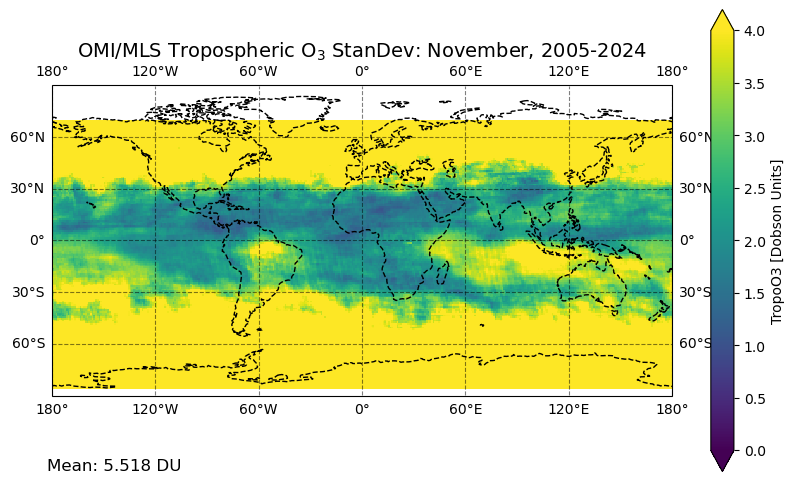

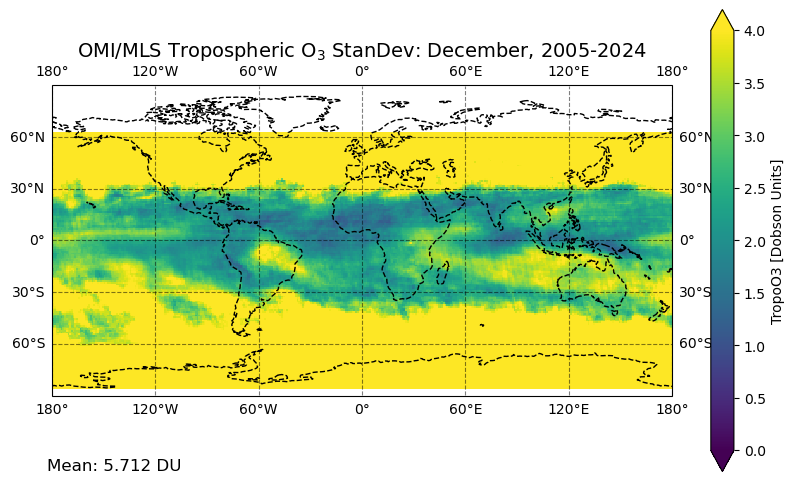

In [19]:
# plot the monthly means

month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'] # for cycling through figures to create a gif

for i in range(12):
    plotting_module.plotting_ozone(monthly_mean, i, "OMI/MLS Tropospheric $\mathregular{O_3}$ Mean:", month_list[i], 3, 5, 75, True)

for i in range(12):
    plotting_module.plotting_ozone(monthly_stdev, i, "OMI/MLS Tropospheric $\mathregular{O_3}$ StanDev:", month_list[i], 3, 0, 4, True)

In [11]:
monthly_stdev.mean()

<xarray.DataArray 'TropoO3' ()> Size: 8B
array(5.42797804)

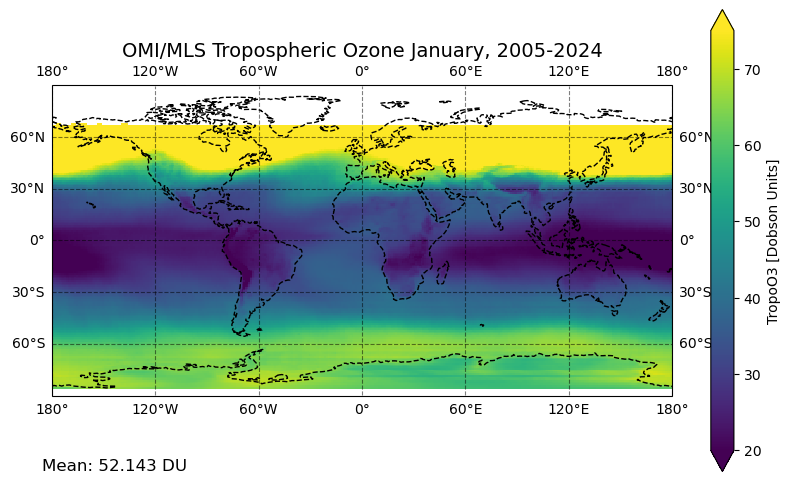

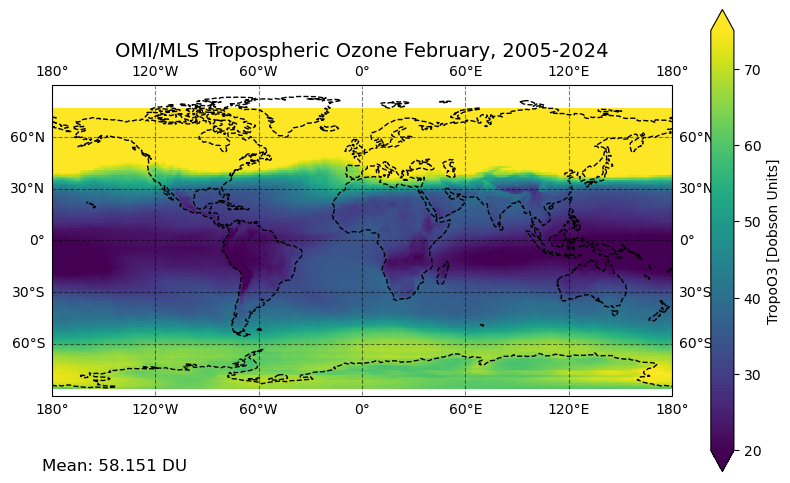

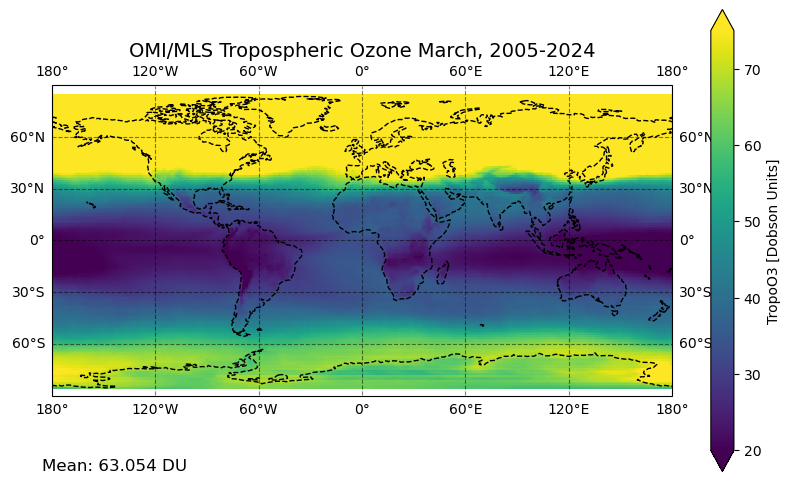

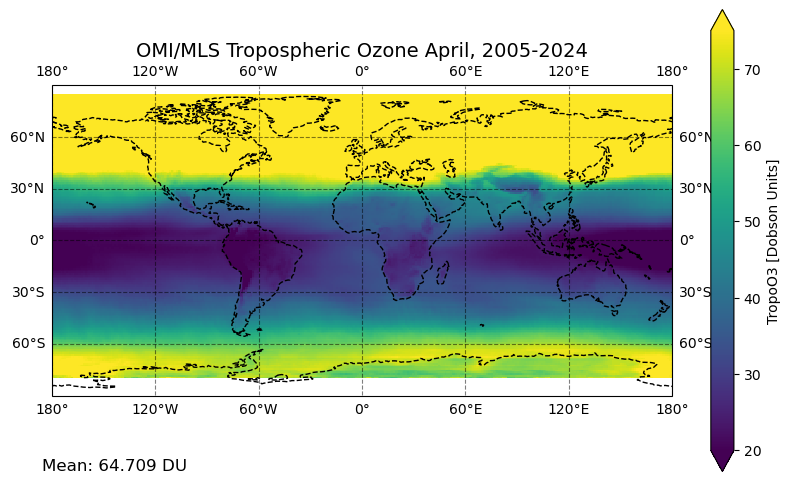

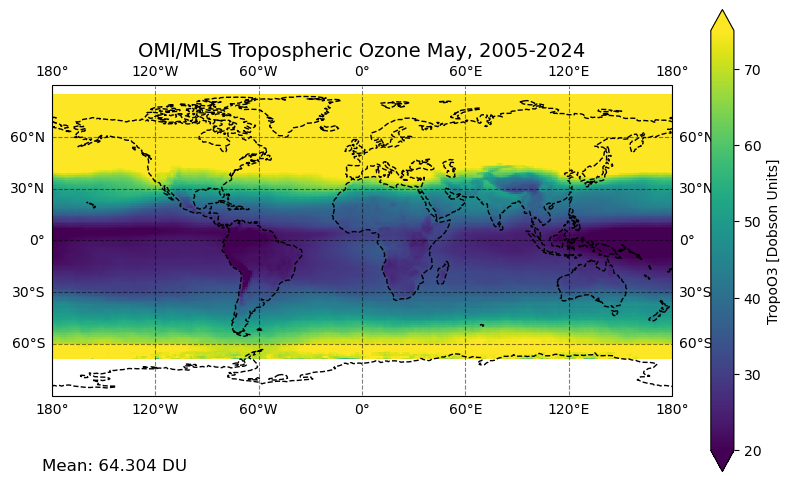

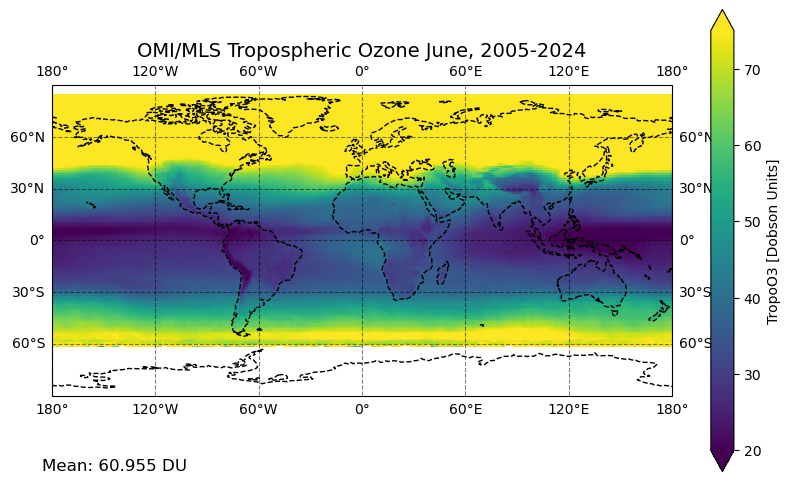

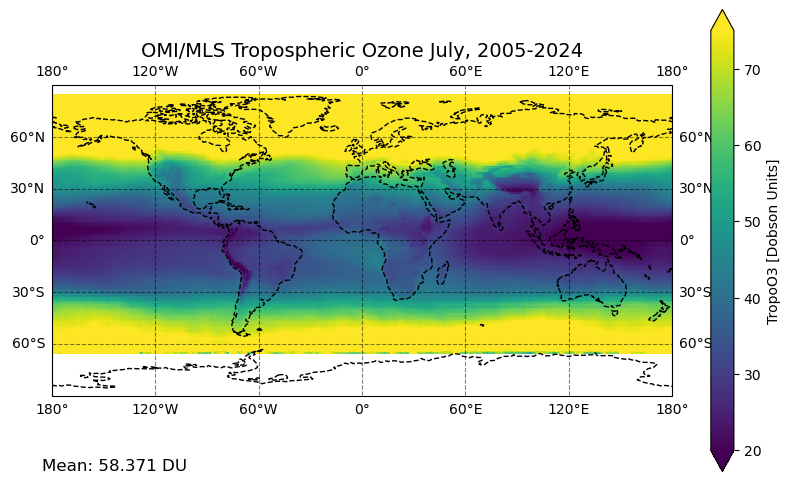

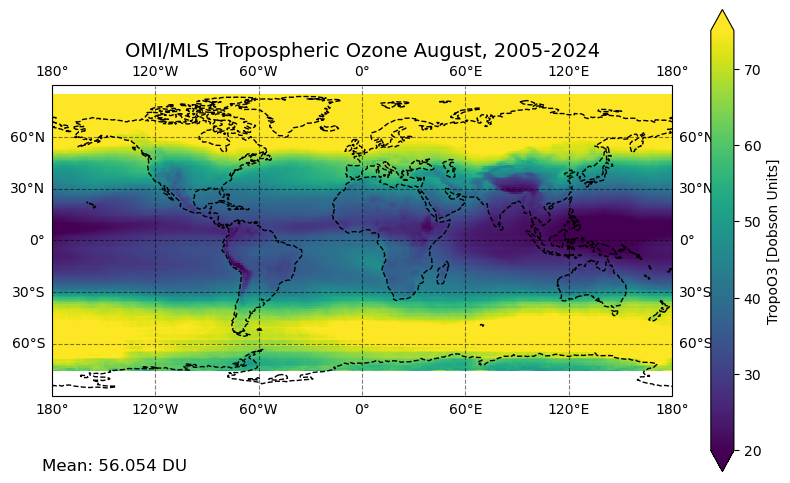

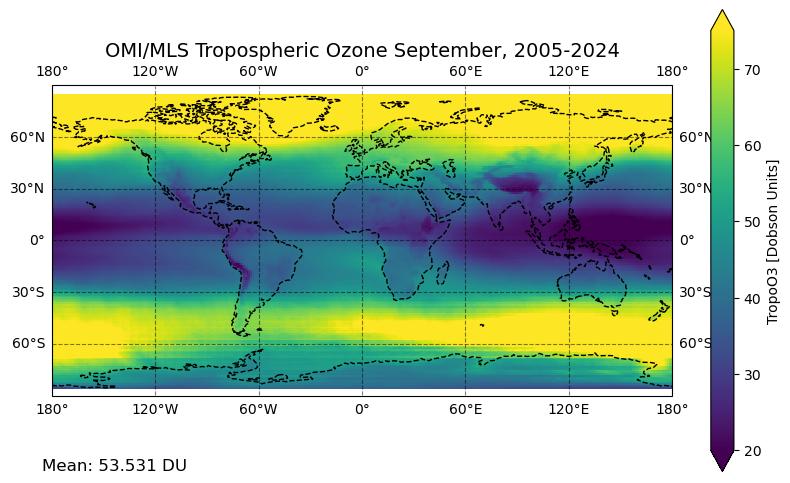

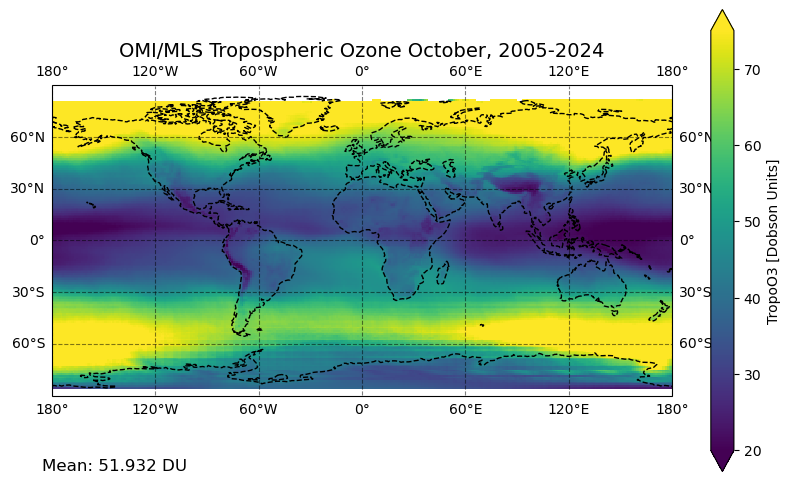

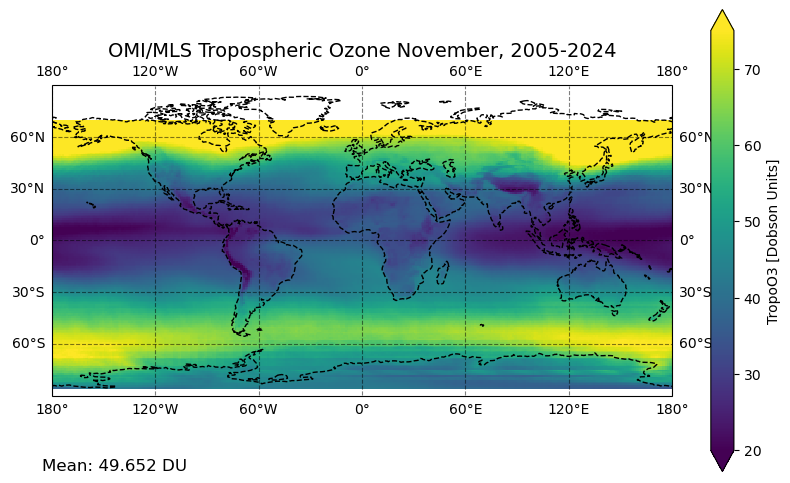

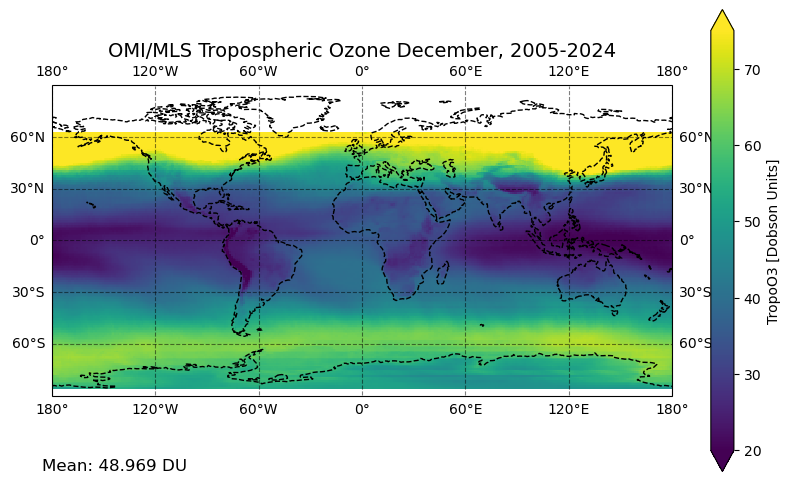

In [20]:
for i in range(12):
    plotting_module.plotting_ozone(monthly_mean, i, "OMI/MLS Tropospheric Ozone", month_list[i], 3, 20, 75, True)

Now truncate to 60S-60N, add fill value, and save as NETCDF4 files

In [13]:
mean_netcdf_dataset = monthly_mean.sel(latitude=slice(-75.5,75.5))

stdev_netcdf_dataset = monthly_stdev.sel(latitude=slice(-75.5,75.5))


In [14]:
mean_netcdf_dataset

<xarray.DataArray 'TropoO3' (month: 12, latitude: 152, longitude: 360)> Size: 3MB
array([[[ 67.68822 ,  67.7697  ,  67.88566 , ...,  68.38742 ,
          68.32687 ,  68.2897  ],
        [ 67.6784  ,  67.67044 ,  67.765045, ...,  68.69369 ,
          68.36792 ,  68.25617 ],
        [ 67.3045  ,  67.26289 ,  67.28155 , ...,  68.15848 ,
          67.88284 ,  67.83311 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[ 71.9485  ,  72.06791 ,  72.18311 , ...,  72.40155 ,
          72.297295,  72.25132 ],
        [ 71.69172 ,  71.72636 ,  71.87551 , ...,  72.57808 ,
          71.96946 ,  71.906525],
        [ 71.16115 ,  71.15555 ,  71.19042 , ...,  71.915405,
          71.46195 ,  71.370865],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[ 64.99811 ,  65.141815,  65.38633 , ...,  63.992603,
          64.00437 ,  63.998165],
        [ 65.12941 ,  65.196266,  65.16689 , ...,  65.38612 ,
          64.90483 ,  64.61473 ],
        [ 65.70442 ,  66.0491  ,  66.23002 , ...,  65.23577 ,
          64.68194 ,  64.68024 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -75.5 -74.5 -73.5 -72.5 ... 73.5 74.5 75.5
Attributes:
    units:       Dobson Units
    name:        Tropospheric Ozone Mean, Ground to 100 hPa
    latitude:    -75.5, -59.5, -58.5, ..., 59.5, 75.5
    longitude:   -179.5, -178.5, ..., 179.5
    _FillValue:  -999

In [15]:
mean_netcdf_dataset.fillna(-999)

<xarray.DataArray 'TropoO3' (month: 12, latitude: 152, longitude: 360)> Size: 3MB
array([[[  67.68822 ,   67.7697  ,   67.88566 , ...,   68.38742 ,
           68.32687 ,   68.2897  ],
        [  67.6784  ,   67.67044 ,   67.765045, ...,   68.69369 ,
           68.36792 ,   68.25617 ],
        [  67.3045  ,   67.26289 ,   67.28155 , ...,   68.15848 ,
           67.88284 ,   67.83311 ],
        ...,
        [-999.      , -999.      , -999.      , ..., -999.      ,
         -999.      , -999.      ],
        [-999.      , -999.      , -999.      , ..., -999.      ,
         -999.      , -999.      ],
        [-999.      , -999.      , -999.      , ..., -999.      ,
         -999.      , -999.      ]],

       [[  71.9485  ,   72.06791 ,   72.18311 , ...,   72.40155 ,
           72.297295,   72.25132 ],
        [  71.69172 ,   71.72636 ,   71.87551 , ...,   72.57808 ,
           71.96946 ,   71.906525],
        [  71.16115 ,   71.15555 ,   71.19042 , ...,   71.915405,
           71.46195 ,   71.370865],
...
        [-999.      , -999.      , -999.      , ..., -999.      ,
         -999.      , -999.      ],
        [-999.      , -999.      , -999.      , ..., -999.      ,
         -999.      , -999.      ],
        [-999.      , -999.      , -999.      , ..., -999.      ,
         -999.      , -999.      ]],

       [[  64.99811 ,   65.141815,   65.38633 , ...,   63.992603,
           64.00437 ,   63.998165],
        [  65.12941 ,   65.196266,   65.16689 , ...,   65.38612 ,
           64.90483 ,   64.61473 ],
        [  65.70442 ,   66.0491  ,   66.23002 , ...,   65.23577 ,
           64.68194 ,   64.68024 ],
        ...,
        [-999.      , -999.      , -999.      , ..., -999.      ,
         -999.      , -999.      ],
        [-999.      , -999.      , -999.      , ..., -999.      ,
         -999.      , -999.      ],
        [-999.      , -999.      , -999.      , ..., -999.      ,
         -999.      , -999.      ]]], dtype=float32)
Coordinates:
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -75.5 -74.5 -73.5 -72.5 ... 73.5 74.5 75.5
Attributes:
    units:       Dobson Units
    name:        Tropospheric Ozone Mean, Ground to 100 hPa
    latitude:    -75.5, -59.5, -58.5, ..., 59.5, 75.5
    longitude:   -179.5, -178.5, ..., 179.5
    _FillValue:  -999

In [22]:
mean_netcdf_dataset.to_netcdf(path="/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_100hpa_monthly_mean_2005_2024.nc",format="NETCDF4")

In [23]:
stdev_netcdf_dataset.fillna(-999)

<xarray.DataArray 'TropoO3' (month: 12, latitude: 152, longitude: 360)> Size: 3MB
array([[[   6.2048907,    6.181857 ,    6.1696177, ...,    6.1308455,
            6.105828 ,    6.101435 ],
        [   6.3359027,    6.402995 ,    6.45779  , ...,    6.1047153,
            6.061098 ,    6.0351534],
        [   5.944087 ,    5.9827175,    6.0223284, ...,    5.7591786,
            5.7808123,    5.810983 ],
        ...,
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ]],

       [[   4.039553 ,    4.0369854,    3.9165394, ...,    3.7756536,
            3.752294 ,    3.7440507],
        [   4.2694736,    4.2382646,    4.1963096, ...,    4.0222893,
            4.0159793,    4.0443845],
        [   4.3578553,    4.358829 ,    4.3405128, ...,    4.056794 ,
            4.040615 ,    4.027877 ],
...
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ]],

       [[   7.677855 ,    7.6396375,    7.595312 , ...,    9.146762 ,
            9.067926 ,    9.044633 ],
        [   8.132752 ,    8.084743 ,    8.205839 , ...,    9.145564 ,
            9.213081 ,    9.341727 ],
        [   7.6322455,    7.5379004,    7.5141225, ...,    8.699458 ,
            9.044306 ,    9.041484 ],
        ...,
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ]]], dtype=float32)
Coordinates:
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -75.5 -74.5 -73.5 -72.5 ... 73.5 74.5 75.5
Attributes:
    units:       Dobson Units
    name:        Tropospheric Ozone STDEV, Ground to 100 hPa
    latitude:    -75.5, -59.5, -58.5, ..., 59.5, 75.5
    longitude:   -179.5, -178.5, ..., 179.5
    _FillValue:  -999

In [24]:
stdev_netcdf_dataset.to_netcdf(path="/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_100hpa_monthly_stdev_2005_2024.nc",format="NETCDF4")